# Dimensionality reduction for MNIST

In [25]:

from __future__ import print_function
import numpy as np
import pandas as pd
import time
from struct import unpack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib import pyplot as plt

## Reuse the brier and AUC function in previous assignment 

In [26]:
def brier_score(df, correctlabels):
    average_square_error = 0
    for i in range(df.shape[0]):
        vec = np.array(df.iloc[i,:])
        index = np.where(df.columns == correctlabels[i])[0]
        correct_vec = [1 if i == index else 0 for i in range(df.shape[1])]
        square_error = np.sum((vec- correct_vec)**2)
        average_square_error += square_error
    average_square_error = average_square_error/df.shape[0]
    return(average_square_error)

def cal_list(prediction_vector, label_vector, label):
    pred = np.array(prediction_vector)
    v = [i == label for i in label_vector] 
    this_label, not_this_label = pred[v], pred[[not i for i in v]]
    scores_false = [0]
    scores_false += sorted(prediction_vector)
    scores_false += [1]
    dict_scores = {}
    for i in scores_false:
        if(len(not_this_label)==0):
            false_pos_i_r = 0
        else:
            false_pos_i_r = np.sum(not_this_label>=i)/len(not_this_label)
        if(len(this_label)==0):
            true_pos_i_r = 0
        else:
            true_pos_i_r = np.sum(this_label>=i)/len(this_label)
        dict_scores[i] = [false_pos_i_r, true_pos_i_r]
    list_reversed = [i for i in reversed(list(dict_scores.values()))]
    return(list_reversed)

def cal_area(list_values):
    area = 0
    if([0,0] not in list_values):
        list_values = [[0,0]]+list_values
    if([1,1] not in list_values):
        list_values = list_values+[[1,1]]
    n = len(list_values)
    for i in range(n-1):
        left, right = i, i+1
        tpr_left, tpr_right = list_values[left][1], list_values[right][1]
        fpr_left, fpr_right = list_values[left][0], list_values[right][0]
        if(fpr_right==fpr_left):
            next
        height = (tpr_left + tpr_right)/2
        width = fpr_right - fpr_left
        area += height * width
    return(area)
    
def auc(df, correctlabels):
    area = 0
    x = pd.Series(correctlabels)
    frequencies = dict(x.value_counts(normalize = True))
    for i in range(1,nClasses+1):
        if(i not in frequencies):
            frequencies = 0
    frequencies = get_frequencies(correctlabels, df.shape[1])
    
    for col in df.columns:
        prediction_vector = df[col]
        l = get_list(prediction_vector, correctlabels, col)
        area_col = get_area(l)
        area += frequencies[col]*area_col
    return(area)

## Load MNIST data set

In [27]:
def __read_image(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        img = np.fromfile(f, dtype=np.uint8).reshape(num, 784)
    return img

def __read_label(path):
    with open(path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        lab = np.fromfile(f, dtype=np.uint8)
    return lab

#normalize the pixel value into 0.0~1.0
def __normalize_image(image):
    img = image.astype(np.float32) / 255.0
    return img

#change digit label into 1 or 0
def __one_hot_label(label):
    lab = np.zeros((label.size, 10))
    for i, row in enumerate(lab):
        row[label[i]] = 1
    return lab

def load_mnist(train_image_path, train_label_path, test_image_path, test_label_path, normalize=True, one_hot=False):
    
    image = {
        'train' : __read_image(train_image_path),
        'test'  : __read_image(test_image_path)}

    label = {
        'train' : __read_label(train_label_path),
        'test'  : __read_label(test_label_path)}

    if normalize:
        for key in ('train', 'test'):
            image[key] = __normalize_image(image[key])

    if one_hot:
        for key in ('train', 'test'):
            label[key] = __one_hot_label(label[key])
            
    return (image['train'], label['train'], image['test'], label['test'])

## Spilt and visualize data set 

Image of digit=8 in training set with mean and var


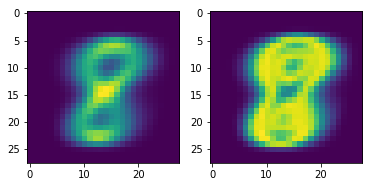

training data points: 12000
testing data points: 2000


In [29]:
#train_data,test_data=load_mnist('train-images-idx3-ubyte','train-labels.idx1-ubyte','t10k-images-idx3-ubyte','t10k-labels.idx1-ubyte')
def vizdata(trainData,trainLabels,digits):
    images=trainData[trainLabels == digits,:]
    
    m0 = np.mean(images,axis=0)
    mean0 = np.reshape(m0, [28,28])
    m1 = np.var(images, axis=0)
    mean1 = np.reshape(m1, [28,28])
    
    return mean0,mean1

#load dataset and spilt 1/10 training data as validation data
(trainData, trainLabels, testData, testLabels)=load_mnist('train-images-idx3-ubyte','train-labels.idx1-ubyte','t10k-images-idx3-ubyte','t10k-labels.idx1-ubyte')
#(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels, test_size=0.1, random_state=84)

#visualize the training data by image, taking 8 as example 
m0,m1=vizdata(trainData, trainLabels, 8)
print("Image of digit=8 in training set with mean and var")
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(m0)
plt.subplot(1, 2, 2)
plt.imshow(m1)
plt.show()

#spilt training data as 10 sub dataset
sub_train_image = np.split(trainData, 5)
sub_train_label = np.split(trainLabels, 5)
sub_test_image = np.split(testData, 5)
sub_test_label = np.split(testLabels, 5)
x_train = sub_train_image[0]
y_train = sub_train_label[0]
x_test = sub_test_image[0]
y_test = sub_test_label[0]

print("training data points: {}".format(len(x_train)))
print("testing data points: {}".format(len(x_test)))

## Apply and Evaluate KNN model with different K value

In [31]:

# initialize the values of k and dataframe
k_values = [1,3,5,7,9,11]
results = np.empty((len(k_values),3))
accuracies = []

#evaluate k-Nearest Neighbor classifier along with accuracy, brier score and AUC
for i in range(len(k_values)):
    
    model = KNeighborsClassifier(n_neighbors = k_values[i])
    model.fit(x_train, y_train)

    score = model.score(x_test, y_test)
    accuracies.append(score)
    
    t0 = time.perf_counter()
    predictions = pd.DataFrame(model.predict_proba(x_test))
    print("Testing time (k={0}): {1:.2f} s.".format(k_values[i], time.perf_counter()-t0))
    results[i] = [score ,brier_score(predictions, y_test),
                  auc(predictions, y_test)] # Assuming that you have defined auc - remove otherwise

results = pd.DataFrame(results, index=k_values, columns=["Accuracy","Brier score","AUC"])

results

Testing time (k=1): 26.47 s.
Testing time (k=3): 27.30 s.
Testing time (k=5): 26.69 s.
Testing time (k=7): 26.22 s.
Testing time (k=9): 26.28 s.
Testing time (k=11): 26.30 s.


,Accuracy,Brier score,AUC
1,0.927,0.146000,0.955542
3,0.925,0.117444,0.979040
5,0.922,0.118040,0.983555
7,0.922,0.121286,0.986619
9,0.918,0.124494,0.988918
11,0.915,0.129066,0.989829


## Choose best k by 5-fold cross validation

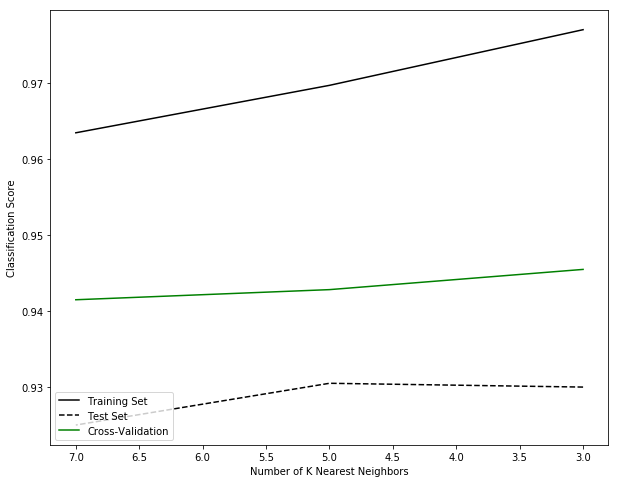

,Train_scores,Test_scores,CV_scores
3,0.977083,0.9300,0.945503
5,0.969750,0.9305,0.942838
7,0.963500,0.9250,0.941505


In [30]:

# the range of number of neighbors you want to test
n_neighbors = [3,5,7]
result = np.empty((len(n_neighbors),3))

# here you store the models for each dataset used
train_scores = list()
test_scores = list()
cv_scores = list()

x_train = sub_train_image[1]
y_train = sub_train_label[1]
x_test = sub_test_image[1]
y_test = sub_test_label[1]

# loop through possible n_neighbors and try them out
for i in range(len(n_neighbors)):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors[i])
    knn.fit(x_train, y_train)
    train_scores = accuracy_score(y_train, knn.predict(x_train)) # this may over-estimate the accuracy
    test_scores = accuracy_score(y_test, knn.predict(x_test))
    cv_scores = cross_val_score(knn, x_train, y_train, cv = 5).mean() # take the mean of the CV scores
    result[i] = [train_scores, test_scores, cv_scores]

result = pd.DataFrame(result, index = n_neighbors, columns=["Train_scores","Test_scores","CV_scores"])

#plot the error we get with different values of k
plt.figure(figsize=(10,8))
plt.plot(n_neighbors, result.iloc[:,0], c="black", label="Training Set")
plt.plot(n_neighbors, result.iloc[:,1], c="black", linestyle="--", label="Test Set")
plt.plot(n_neighbors, result.iloc[:,2], c="green", label="Cross-Validation")
plt.xlabel('Number of K Nearest Neighbors')
plt.ylabel('Classification Score')
plt.gca().invert_xaxis()
plt.legend(loc = "lower left")
plt.show()

result

## 1. PCA 

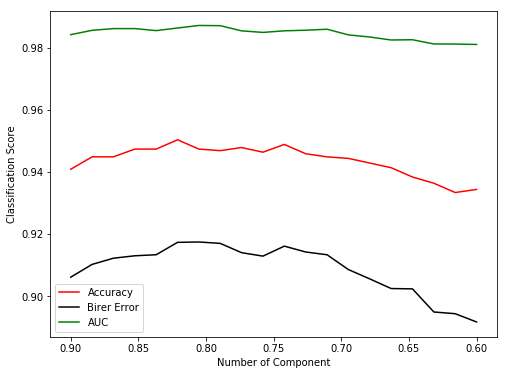

,N_Component,Time,Accuracy,Brier score,AUC
1,0.600000,1.074950,0.9345,0.108222,0.981223
2,0.615789,1.038091,0.9335,0.105556,0.981350
3,0.631579,1.146149,0.9365,0.105000,0.981382
4,0.647368,1.291609,0.9385,0.097556,0.982747
5,0.663158,1.237070,0.9415,0.097444,0.982665
6,0.678947,1.452211,0.9430,0.094333,0.983623
7,0.694737,1.370479,0.9445,0.091333,0.984313
8,0.710526,1.678554,0.9450,0.086556,0.986130
9,0.726316,1.603594,0.9460,0.085667,0.985815
10,0.742105,1.805202,0.9490,0.083778,0.985625


In [36]:
def ana_pca(n_s, x_train, y_train, x_test, y_test):
    result_pca = np.empty((len(n_s),5))
    for i in range(len(n_s)):
        t0 = time.perf_counter()
        pca = PCA(n_components=n_s[i])
        pca.fit(x_train)

        # reduce dimension on training and test dataset 
        x_train_pca = pca.transform(x_train)
        x_val_pca = pca.transform(x_test)
        # train model with best K value
        model = KNeighborsClassifier(n_neighbors = 3)
        model.fit(x_train_pca, y_train)

        # evaluate model
        accuracy = model.score(x_val_pca, y_test)          
        predictions = pd.DataFrame(model.predict_proba(x_val_pca))
        t1 = time.perf_counter()

        result_pca[i] = [n_s[i], t1 - t0, accuracy ,brier_score(predictions, y_test),
                      auc(predictions, y_test)]
    return result_pca


n_s = np.linspace(0.60, 0.90, num=20)

result_pca = ana_pca(n_s, x_train, y_train, x_test, y_test)
result_pca = pd.DataFrame(result_pca, index = np.arange(1,21), columns=["N_Component", "Time", "Accuracy", "Brier score","AUC"])

error=[]
for i in result_pca.iloc[:,3]:
    error.append(1-i)
plt.figure(figsize=(8,6))
plt.plot(result_pca.iloc[:,0], result_pca.iloc[:,2], c="red", label="Accuracy")
plt.plot(result_pca.iloc[:,0], error, c="black", label="Birer Error")
plt.plot(result_pca.iloc[:,0], result_pca.iloc[:,4], c="green", label="AUC")
plt.xlabel('Number of Component')
plt.ylabel('Classification Score')
plt.gca().invert_xaxis()
plt.legend(loc = "lower left")
plt.show()

result_pca

by comparing the value of accuracy, birer score and auc, we can find the best N_componet=0.8

## 2. LDA

In [40]:
def ana_lda(n_s, x_train, y_train, x_test, y_test):
    accuracy = []
    result_lda = np.empty((len(n_s),5))
    for i in range(len(n_s)):
        t0 = time.perf_counter()
        lda = LinearDiscriminantAnalysis(n_components=n_s[i], priors=None, shrinkage=None,
                  solver='svd', store_covariance=False, tol=0.0001)
        lda.fit(x_train, y_train)

        # reduce dimension on training and test dataset 
        x_train_lda = lda.transform(x_train)
        x_val_lda = lda.transform(x_test)
        # train model with best K value
        model = KNeighborsClassifier(n_neighbors = 3)
        model.fit(x_train_lda, y_train)

        # evaluate model
        accuracy = model.score(x_val_lda, y_test)         
        predictions = pd.DataFrame(model.predict_proba(x_val_lda))
        t1 = time.perf_counter() 

        result_lda[i] = [n_s[i], t1 - t0, accuracy ,brier_score(predictions, y_test),
                      auc(predictions, y_test)] 
    return result_lda

# compontent of LDA should be less than number of classes, 1-9
n_s = np.arange(2, 11)
result_lda = ana_lda(n_s, x_train, y_train, x_test, y_test)

result_lda = pd.DataFrame(result_lda, index=np.arange(1,10), columns=["N_Componet", "Time", "Accuracy", "Brier score","AUC"])
result_lda

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

,N_Componet,Time,Accuracy,Brier score,AUC
1,2.0,2.038958,0.4900,0.745444,0.789523
2,3.0,1.735220,0.6410,0.534222,0.862017
3,4.0,1.926214,0.7605,0.384111,0.909115
4,5.0,1.968284,0.7675,0.366000,0.915530
5,6.0,1.819352,0.8030,0.304333,0.934629
6,7.0,1.879629,0.8330,0.273111,0.940275
7,8.0,1.877723,0.8555,0.229889,0.950593
8,9.0,1.984806,0.8595,0.222778,0.952122
9,10.0,1.968221,0.8595,0.222778,0.952122


## 3. LLE

In [21]:
def ana_lle(n_s, x_train, y_train, x_test, y_test):
    accuracy = []
    result_lle = np.empty((len(n_s),5))
    for i in range(len(n_s)):
        t0 = time.perf_counter()

        lle = LocallyLinearEmbedding(n_components = n_s[i],method = 'standard')
        lle.fit(x_train, y_train)
        x_train_lle = lle.transform(x_train)
        x_val_lle = lle.transform(x_test)
        model = KNeighborsClassifier(n_neighbors = 3)
        model.fit(x_train_lle, y_train)

        # evaluate model
        accuracy = model.score(x_val_lle, y_test)         
        predictions = pd.DataFrame(model.predict_proba(x_val_lle))
        t1 = time.perf_counter()

        result_lle[i] = [n_s[i], t1 - t0, accuracy ,brier_score(predictions, y_test),
                      auc(predictions, y_test)] 
    return result_lle

n_s = np.arange(3, 23)
result_lle = ana_lle(n_s, x_train, y_train, x_test, y_test)

result_lle = pd.DataFrame(result_lle, index=np.arange(1,21), columns=["N_Componet", "Time", "Accuracy", "Brier score","AUC"])
result_lle

,N_Componet,Time,Accuracy,Brier score,AUC
1,3.0,370.023542,0.8425,0.257444,0.942086
2,4.0,369.753690,0.8640,0.226556,0.949563
3,5.0,363.581998,0.8690,0.208333,0.952349
4,6.0,358.294027,0.8785,0.196444,0.956926
5,7.0,361.217367,0.8985,0.170222,0.964011
6,8.0,361.259357,0.9065,0.162444,0.965394
7,9.0,462.305790,0.9035,0.164111,0.965822
8,10.0,462.957538,0.9065,0.161667,0.965145
9,11.0,498.236641,0.9060,0.161444,0.965205
10,12.0,504.899835,0.9080,0.156333,0.966656


## Test with optimal parameter value

In [44]:
#select new part of dataset
x_train = sub_train_image[3]
y_train = sub_train_label[3]
x_test = sub_test_image[3]
y_test = sub_test_label[3]

#define the best value for component 
n_pca = [0.8]
n_lda = [9]
n_lle = [20]

#train and test knn model 
t = time.perf_counter()
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)
predictions = pd.DataFrame(model.predict_proba(x_test))
t = time.perf_counter() - t

#get the score of PCA, LDA and standard LLE
test = np.empty((4,5))
test[0] = [3, t, accuracy ,brier_score(predictions, y_test),
                  auc(predictions, y_test)]
test[1] = ana_pca(n_pca, x_train, y_train, x_test, y_test)
test[2] = ana_lda(n_lda, x_train, y_train, x_test, y_test)
test[3] = ana_lle(n_lle, x_train, y_train, x_test, y_test)

test = pd.DataFrame(test, index = ["k-NN", "PCA", "LDA", "LLE"], columns=["N_Component", "Time", "Accuracy", "Brier score","AUC"])
test

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,N_Component,Time,Accuracy,Brier score,AUC
k-NN,3.0,55.169387,0.9725,0.040333,0.995106
PCA,0.8,2.801048,0.9770,0.034000,0.995513
LDA,9.0,2.006142,0.9105,0.142000,0.971167
LLE,20.0,488.075535,0.9600,0.064778,0.987809


## Test with face recognition dataset

In [48]:
X = np.genfromtxt('olivettifacesX.txt', delimiter=',')
x = X/255
y = np.genfromtxt('olivettifacesY.txt', delimiter=',',dtype=np.int)
pcadim = 20
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2, random_state=84)
print("training data points: {}".format(len(x_train)))
print("test data points: {}".format(len(x_test)))

training data points: 320
test data points: 80


In [58]:
#define the best value for component 
n_pca = [0.8]
n_lda = [9]
n_lle = [20]

#train and test knn model 
t = time.perf_counter()
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)
predictions = pd.DataFrame(model.predict_proba(x_test))
t = time.perf_counter() - t

#get the score of PCA, LDA and standard LLE
test = np.empty((4,5))
test[0] = [3, t, accuracy ,brier_score(predictions, y_test),
                  auc(predictions, y_test)]
test[1] = ana_pca(n_pca, x_train, y_train, x_test, y_test)
test[2] = ana_lda(n_lda, x_train, y_train, x_test, y_test)
test[3] = ana_lle(n_lle, x_train, y_train, x_test, y_test)

test = pd.DataFrame(test, index = ["k-NN", "PCA", "LDA", "LLE"], columns=["N_Component", "Time", "Accuracy", "Brier score","AUC"])
test

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,N_Component,Time,Accuracy,Brier score,AUC
k-NN,3.0,0.375963,0.8375,0.208333,0.985247
PCA,0.8,0.125365,0.8125,0.238889,0.983718
LDA,9.0,0.271996,0.9000,0.150000,0.967781
LLE,20.0,1.652143,0.7125,0.413889,0.918205
